<a href="https://colab.research.google.com/github/NabilahSharfina/TELCO-CUSTOMER-CHURN/blob/main/Churn_without_SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id="1"></a>
# A. Problem Statement

<p>
    <quote>
    
    Churn data for a fictional Telecommunications company that
    provides phone and internet services to 7,043 customers in
    California, and includes details about customer demographics,
    location, services, and current status.

    Recommended Analysis:
    * How many customers joined the company during the last quarter?
    * How many customers joined?
    * What is the customer profile for a customer that churned, joined, and stayed? Are they different?
    * What seem to be the key drivers of customer churn?
    * Is the company losing high value customers? If so, how can they retain them?
</p>
<p>Background Source: <a href="https://www.mavenanalytics.io/data-playground">Latar Belakang Telco Churn</a></p>
<br/>
<p><strong>There is a big competition between Internet providers. If a providers want to increase its revenue they needs more subscriber but keep existing customer is more important than having new ones. So providers want to know which customer should cancel his service. we call this as churn. if the know who will go, maybe they can catch them with promotions.</strong></p>
<p>Dataset Source: <a href="https://www.mavenanalytics.io/data-playground">Maven Analytics</a></p>

# B. Connect Google Drive

In [ ]:
# Load data from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# C. Import Library

In [ ]:
import math
from collections import Counter
from pprint import pprint

import pandas as pd # for handling and cleaning the dataset
import numpy as np # for performing mathematical calculations behind ML algorithms
import matplotlib.pyplot as plt # for visualization
import seaborn as sns # for visualization

# One Hot Encoding: digunakan untuk bukan tipe data ordinal, misal nominal, interval, dan ratio
from sklearn.preprocessing import OneHotEncoder
# Ordinal Encoding: digunakan untuk tipe data ordinal
from sklearn.preprocessing import OrdinalEncoder

# Scalling Data
from sklearn.preprocessing import MinMaxScaler

# Handle imbalance dataset
from imblearn.over_sampling import SMOTE

# Splitting Data
from sklearn.model_selection import train_test_split

# Modelling
!pip install lightgbm
import lightgbm as lgbm
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# For feature importance
from sklearn.datasets import make_classification

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. Data Preprocessing

## 1.1 Data Loading

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/ITTP/KULIAH/SEMESTER 7/TUGAS AKHIR 2/IBM Dataset/IBM-Telco-Customer-Churn.csv")
# df.drop('customerID', axis=1, inplace=True)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


> In the context of customer churn, tenure refers to the length of time that a customer has been a subscriber or a customer of a company. It is typically measured in months.
Tenure is an important feature to consider when analyzing customer churn as it can provide insights into how long customers have been engaged with the company and how loyal they are likely to be. Customers with longer tenure may be less likely to leave the company compared to newer customers.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
# This column had missing values represented by ' '
# I noticed it when I tried converting it to float 
# and it gave me an error that it could not convert "string to float"
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.NaN)
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [ ]:
df.dtypes.value_counts()

object     17
int64       2
float64     2
dtype: int64

In [ ]:
# Melihat apakah ada missing value dari dataset
df.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [ ]:
# Mengisi missing value dengan nilai median
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Melihat apakah ada missing value dari dataset
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [ ]:
# Mengecek baris yang duplikat
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
7038    False
7039    False
7040    False
7041    False
7042    False
Length: 7043, dtype: bool

## 1.2 Data Exploration

In [ ]:
# df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})
# df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# df.head()

In [ ]:
df.Churn.value_counts()
# 0 = No
# 1 = Yes

No     5174
Yes    1869
Name: Churn, dtype: int64

In [ ]:
print ('Total Customer Loyal\t: {}'.format(df.Churn.value_counts()['No']))
print ('Total Customer Churn\t: {}'.format(df.Churn.value_counts()['Yes']))

Total Customer Loyal	: 5174
Total Customer Churn	: 1869


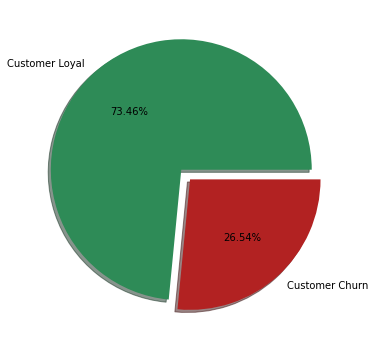

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.pie(x=df["Churn"].value_counts(),
        colors=["seagreen", "firebrick"], 
        labels=["Customer Loyal", "Customer Churn"], 
        shadow = True, 
        autopct="%1.2f%%",
        explode=(0, 0.1)
        )

plt.show()

In [ ]:
df.gender.value_counts()
# 0 = Laki-laki
# 1 = Perempuan

Male      3555
Female    3488
Name: gender, dtype: int64

In [ ]:
print ('Total Laki-laki\t: {}'.format(df.gender.value_counts()['Male']))
print ('Total Perempuan\t: {}'.format(df.gender.value_counts()['Female']))

Total Laki-laki	: 3555
Total Perempuan	: 3488


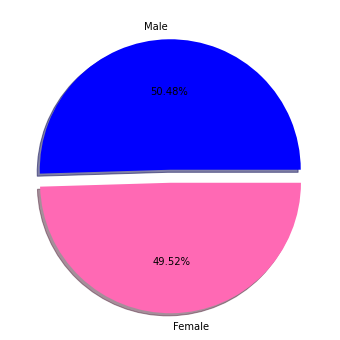

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.pie(x=df["gender"].value_counts(), 
        colors=["blue", "hotpink"], 
        labels=["Male", "Female"], 
        shadow = True, 
        autopct="%1.2f%%", 
        explode=(0, 0.1)
        )

plt.show()

In [ ]:
# Grouping
group = df.groupby('gender').Churn.value_counts()
gender_status = pd.crosstab(df.gender, df.Churn)

print(group)
gender_status

gender  Churn
Female  No       2549
        Yes       939
Male    No       2625
        Yes       930
Name: Churn, dtype: int64


Churn,No,Yes
gender,,
Female,2549,939
Male,2625,930


## 1.3 Feature Category

In [ ]:
# Mengetahui kolom apa saja yang termasuk fitur (variabel) numerik/kategoris
numerical_features = df.select_dtypes(include="number").columns.tolist()
categorical_features = df.select_dtypes(include="object").columns.tolist()

print("Numerical features:")
pprint(numerical_features)
print("\nCategorical features:")
pprint(categorical_features, compact=True)

Numerical features:
['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

Categorical features:
['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


In [ ]:
columns = df.columns
print("********** Numeric field **********n")
for i in range(len(columns)):
    if df[columns[i]].dtypes!=object:
        print("Unique of {} -> {}".format(columns[i], len(df[columns[i]].unique())))
        
print("\n********** Categorical field **********n")
for i in range(len(columns)):
    if df[columns[i]].dtypes==object:
        print("Unique of {} -> {}".format(columns[i], len(df[columns[i]].unique())))

********** Numeric field **********n
Unique of SeniorCitizen -> 2
Unique of tenure -> 73
Unique of MonthlyCharges -> 1585
Unique of TotalCharges -> 6531

********** Categorical field **********n
Unique of customerID -> 7043
Unique of gender -> 2
Unique of Partner -> 2
Unique of Dependents -> 2
Unique of PhoneService -> 2
Unique of MultipleLines -> 3
Unique of InternetService -> 3
Unique of OnlineSecurity -> 3
Unique of OnlineBackup -> 3
Unique of DeviceProtection -> 3
Unique of TechSupport -> 3
Unique of StreamingTV -> 3
Unique of StreamingMovies -> 3
Unique of Contract -> 3
Unique of PaperlessBilling -> 2
Unique of PaymentMethod -> 4
Unique of Churn -> 2


In [ ]:
for i in range(len(categorical_features)):
    print("********** {} **********".format(categorical_features[i]))
    print(df[categorical_features[i]].unique(), "\n")

********** customerID **********
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK'] 

********** gender **********
['Female' 'Male'] 

********** Partner **********
['Yes' 'No'] 

********** Dependents **********
['No' 'Yes'] 

********** PhoneService **********
['No' 'Yes'] 

********** MultipleLines **********
['No phone service' 'No' 'Yes'] 

********** InternetService **********
['DSL' 'Fiber optic' 'No'] 

********** OnlineSecurity **********
['No' 'Yes' 'No internet service'] 

********** OnlineBackup **********
['Yes' 'No' 'No internet service'] 

********** DeviceProtection **********
['No' 'Yes' 'No internet service'] 

********** TechSupport **********
['No' 'Yes' 'No internet service'] 

********** StreamingTV **********
['No' 'Yes' 'No internet service'] 

********** StreamingMovies **********
['No' 'Yes' 'No internet service'] 

********** Contract **********
['Month-to-month' 'One year' 'Two year'] 

********** PaperlessBilling **********

In [ ]:
for i in range(len(numerical_features)):
    print("********** {} **********".format(numerical_features[i]))
    print(df[numerical_features[i]].unique(), "\n")

********** SeniorCitizen **********
[0 1] 

********** tenure **********
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39] 

********** MonthlyCharges **********
[29.85 56.95 53.85 ... 63.1  44.2  78.7 ] 

********** TotalCharges **********
[  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ] 



## 1.4 Correlation Data

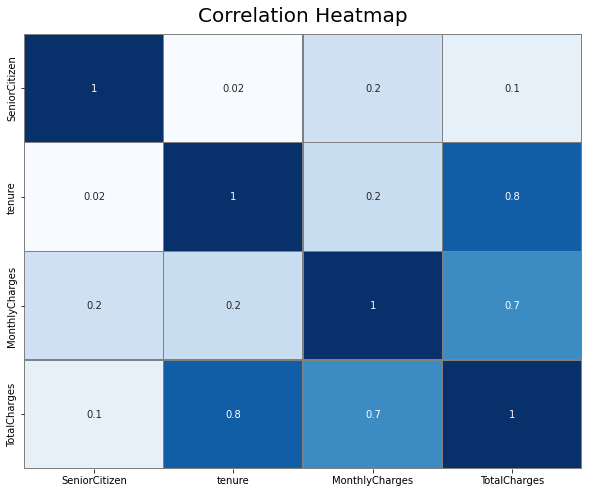

In [ ]:
# Having a look at the correlation matrix
fig, ax = plt.subplots(figsize=(10, 8))
heatmap = sns.heatmap(df.corr(), annot=True, fmt='.1g', cmap=plt.cm.Blues, cbar=False, linewidths=0.5, linecolor='grey')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12);

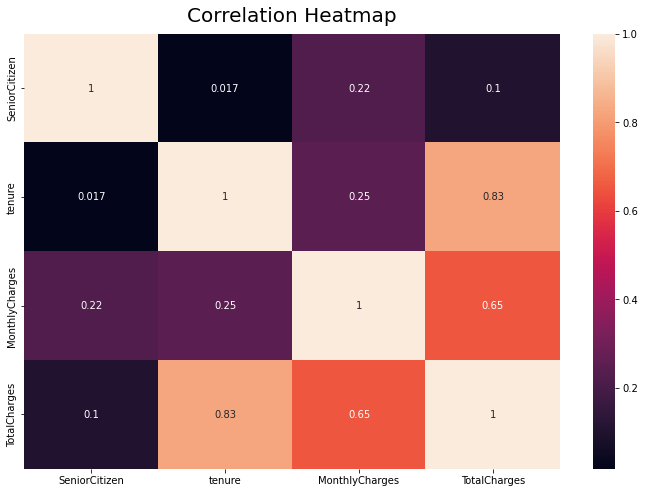

In [ ]:
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(df.corr(), annot = True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12);

In [ ]:
# fig, ax = plt.subplots(3, 3, figsize = (20, 15))

# plt.suptitle('Count plot for various categorical features', fontsize = 30, color= 'teal')

# ax1 = sns.countplot(x ='PhoneService', data= data, hue= 'Churn', ax= ax[0, 0], palette= 'spring')
# ax1.set(xlabel = 'Phone Service')

# ax2 = sns.countplot(x ='MultipleLines', data= data, hue= 'Churn', ax= ax[0, 1], palette= 'winter')
# ax2.set(xlabel = 'MultipleLines')

# ax3 = sns.countplot(x ='InternetService', data= data, hue= 'Churn', ax= ax[0, 2], palette= 'summer')
# ax3.set(xlabel = 'Internet Service')

# ax4 = sns.countplot(x ='OnlineSecurity', data= data, hue= 'Churn', ax= ax[1, 0], palette= 'ocean')
# ax4.set(xlabel = 'Online Security')

# ax5 = sns.countplot(x ='OnlineBackup', data= data, hue= 'Churn', ax= ax[1, 1], palette= 'autumn')
# ax5.set(xlabel = 'Online Backup')

# ax6 = sns.countplot(x ='DeviceProtection', data= data, hue= 'Churn', ax= ax[1, 2], palette= 'YlGnBu')
# ax6.set(xlabel = 'Device Protection')

# ax7 = sns.countplot(x ='TechSupport', data= data, hue= 'Churn', ax= ax[2, 0], palette= 'copper')
# ax7.set(xlabel = 'Tech support')

# ax8 = sns.countplot(x ='StreamingTV', data= data, hue= 'Churn', ax= ax[2, 1], palette= 'plasma')
# ax8.set(xlabel = 'Streaming TV')

# ax9 = sns.countplot(x ='StreamingMovies', data= data, hue= 'Churn', ax= ax[2, 2], palette= 'bone')
# ax9.set(xlabel = 'Streaming Movies')

# plt.tight_layout()
# plt.show()

Text(0.5, 0, 'TotalCharges')

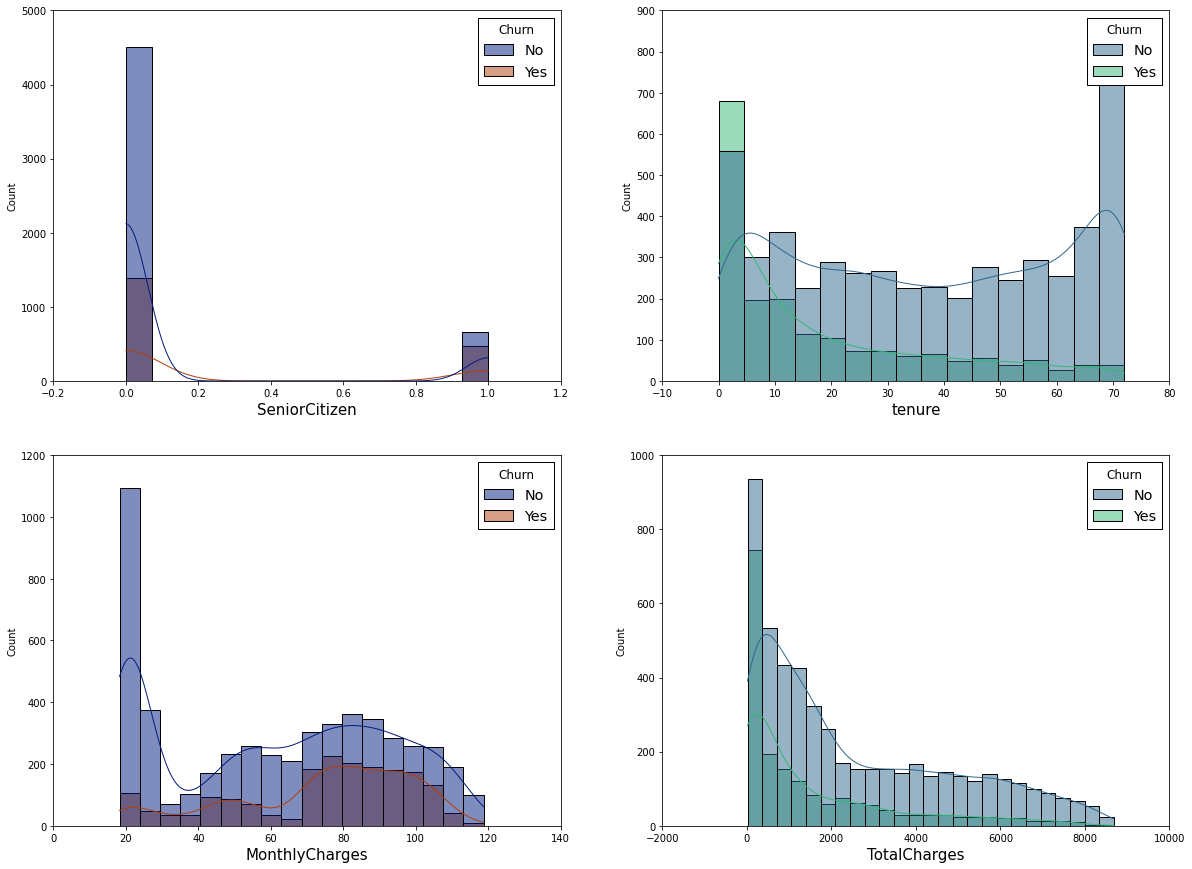

In [ ]:
fig, ax=plt.subplots(2, 2, figsize=(20, 15)) 
plt.style.use("classic")

sns.histplot(x=df["SeniorCitizen"], hue=df["Churn"], palette="dark", kde=True, ax=ax[0,0]);
ax[0,0].set_xlabel("SeniorCitizen", fontsize=15)

sns.histplot(x=df["tenure"], hue=df["Churn"], palette="viridis", kde=True, ax=ax[0,1]);
ax[0,1].set_xlabel("tenure", fontsize=15)

sns.histplot(x=df["MonthlyCharges"], hue=df["Churn"], palette="dark", kde=True, ax=ax[1,0]);
ax[1,0].set_xlabel("MonthlyCharges", fontsize=15)

sns.histplot(x=df["TotalCharges"], hue=df["Churn"], palette="viridis", kde=True, ax=ax[1,1]);
ax[1,1].set_xlabel("TotalCharges", fontsize=15)

## 1.5 Handling Outlier

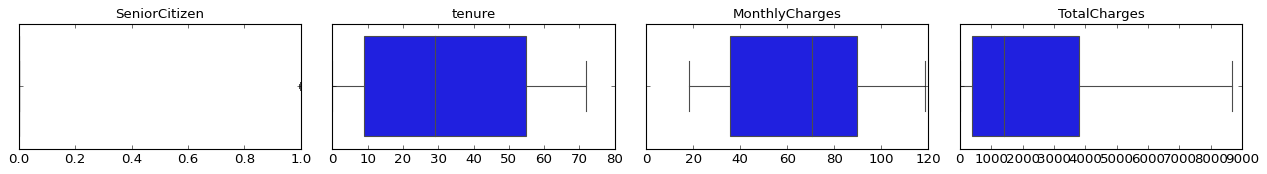

In [ ]:
# Numerical Features
plt.figure(figsize=(16, 8), facecolor='white')
plotnumber = 1
    
for feature in numerical_features:
    ax = plt.subplot(4, 4, plotnumber)
    sns.boxplot(x=feature, data=df);
    plt.title(feature, fontsize=12)
    plt.xlabel(None)
    plt.tight_layout()
    plotnumber += 1

> Ada beberapa cara untuk menghilangkan outliers.
* Mengganti nilai outliers menggunakan nilai lower bound dan upper bound.
* Capping menggunakan nilai median
* Capping menggunakan nilai mean
* Capping menggunakan nilai modus

> **Referensi:** [handling outlier](https://blog.sanbercode.com/docs/materi-eda/data-type-missing-value-outlier/)

In [ ]:
# Membuat function IQR Detection
def outlier(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    limit = iqr * 1.5
    print(f'IQR: {iqr}')
    upperlimit = q3 + limit
    lowerlimit = q1 - limit
    print(f'Upper Limit: {upperlimit}')
    print(f'Lower Limit: {lowerlimit}')

# Buang Outlier
outlier_feature = [
                   'tenure',
                   'MonthlyCharges',
                   'TotalCharges'
                    ]

for i in outlier_feature:
    print(i)
    outlier(df[i])
    print()

df = df[
        (df['tenure'] < 124.0) & 
        (df['MonthlyCharges'] < 171.375) &
        (df['TotalCharges'] < 8887.525)
        ]

tenure
IQR: 46.0
Upper Limit: 124.0
Lower Limit: -60.0

MonthlyCharges
IQR: 54.349999999999994
Upper Limit: 171.375
Lower Limit: -46.02499999999999

TotalCharges
IQR: 3384.375
Upper Limit: 8863.1625
Lower Limit: -4674.3375



In [ ]:
# Clean dataframe from outlier
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# 4. Split Data

In [ ]:
# Define variable X (Independent variable / features)
X = df.drop('Churn', axis=1)

# Define variable y (Dependent variable / Target features)
Y = df["Churn"]

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

* X_train: Untuk menampung data source yang akan dilatih.
* X_test: Untuk menampung data target yang akan dilatih.
* Y_train: Untuk menampung data source yang akan digunakan untuk testing.
* Y_test: Untuk menampung data target yang akan digunakan untuk testing.

In [ ]:
len(X_train), len(X_test)

(5634, 1409)

In [ ]:
print("Data Train:")
pprint(Y_train.value_counts())

print("\nData Test:")
pprint(Y_test.value_counts())

Data Train:
No     4138
Yes    1496
Name: Churn, dtype: int64

Data Test:
No     1036
Yes     373
Name: Churn, dtype: int64


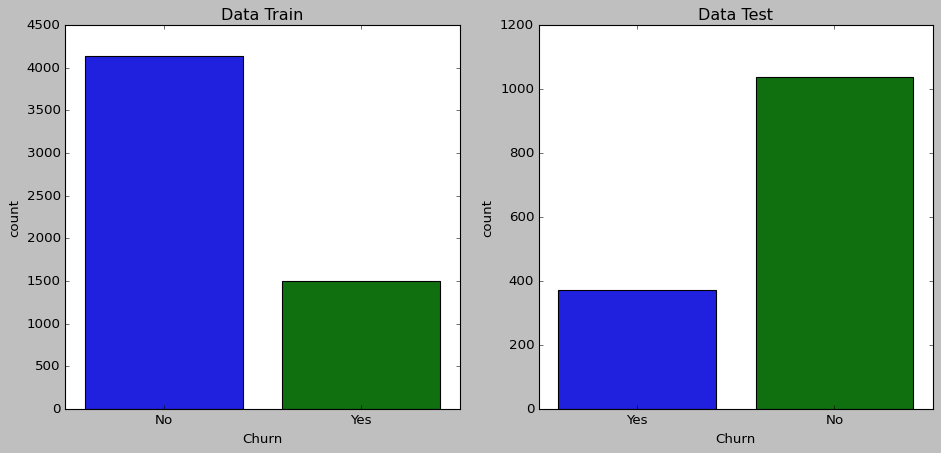

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(14, 6))
for idx, label in enumerate([
    (Y_train, "Data Train"), (Y_test, "Data Test")
]):
    sns.countplot(x=label[0], ax=axis[idx])
    axis[idx].set_title(label[1])
    axis[idx].grid(False)
plt.show()

# 2. Categorical Encoding

> **Note:** Jenis-Jenis Tipe Data
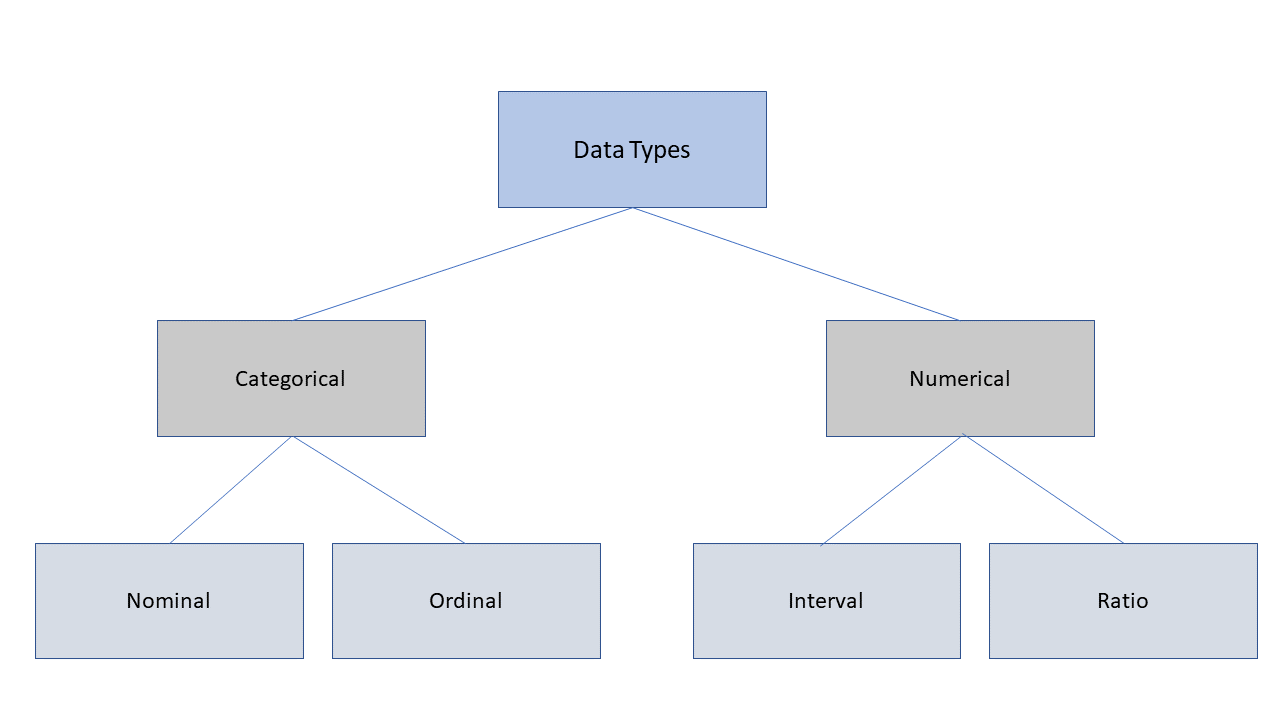

1. Data Nominal: Data nominal adalah data yang dapat diklasifikasikan ke dalam kategori atau label tanpa urutan tertentu. Contoh: jenis kelamin (Pria/Wanita), warna (Merah/Biru/Hijau), dll.
2. Data Ordinal: Data ordinal adalah data yang dapat diklasifikasikan ke dalam kategori atau label dengan urutan tertentu. Contoh: tingkat pendidikan (SD/SMP/SMA/Perguruan Tinggi), tingkat kesukaan (Sangat Tidak Suka/Tidak Suka/Netral/Suka/Sangat Suka), dll.
3. Data Interval: Data interval adalah data yang dapat diukur dalam skala yang tidak terbatas namun tidak memiliki nilai nol absolut. Contoh: suhu dalam derajat Fahrenheit, skala IQ, dll.
4. Data Rasio: Data rasio adalah data yang dapat diukur dalam skala yang tidak terbatas dan memiliki nilai nol absolut. Contoh: berat badan, tinggi badan, dll.

> **NOTE:**
> Perbedaan utama antara tipe data tersebut terletak pada cara data diukur dan diinterpretasikan. Data nominal hanya dapat di klasifikasikan, data ordinal memiliki urutan, data interval tidak memiliki nilai nol absolut, sementara data rasio memiliki nilai nol absolut sehingga dapat diukur perbandingannya.

1. Data kontinu: Data kontinu adalah data yang dapat diukur dalam skala yang tidak terbatas, seperti suhu, berat, tinggi, dll. Data ini dapat dinyatakan dalam bentuk angka decimal. Contoh : suhu tubuh, berat badan, tinggi badan, dll.
2. Data diskrit: Data diskrit adalah data yang dapat dihitung dan dinyatakan dalam bentuk angka bulat. Data diskrit dapat diklasifikasikan ke dalam kategori atau label. Contoh : jumlah anak, jenis kelamin, jenis pekerjaan, dll.
3. Data binari: Data binari adalah data yang hanya dapat memiliki dua nilai, yaitu 0 atau 1. Data ini sering digunakan dalam klasifikasi biner (binary classification), dimana setiap sampel diklasifikasikan sebagai kategori positif atau negatif. Contoh : status menikah (Menikah/Belum Menikah), status memiliki kartu kredit (ya/tidak), dll.

> **NOTE:**
> Perbedaan utama antara data kontinu, diskrit dan binari terletak pada cara data diukur dan diinterpretasikan. Data kontinu diukur dalam skala yang tidak terbatas, data diskrit diukur dalam skala yang terbatas dan dapat dihitung, sementara data binari hanya memiliki dua nilai yang mungkin.

* Dilihat dari isi value masing-masing fitur, maka encoding akan terbagi menjadi 2 yaitu: 
> 1. ***Label Encoding*** untuk fitur kategorik tipe data ordinal seperti `Contract`, `MultipleLines`, dll.
> 2. ***One Hot Encoding*** untuk fitur kategorik tipe data nominal, interval, dan rasio seperti `InternetService` dan `PaymentMethod`.

In [ ]:
print("Jumlah X Train", X_train.shape)
print("Jumlah X Test", X_test.shape)

Jumlah X Train (5634, 20)
Jumlah X Test (1409, 20)


In [ ]:
# Untuk Uji One Hot Encoding
nominal_data = ['gender', 'InternetService', 'PaymentMethod']
ordinal_data = X.select_dtypes(include="object").drop(columns=nominal_data).columns.tolist()

# Untuk Uji Label Encoding
print("Nominal Data:")
pprint(nominal_data)
print("\nOrdinal Data:")
pprint(ordinal_data, compact=True)

Nominal Data:
['gender', 'InternetService', 'PaymentMethod']

Ordinal Data:
['customerID', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling']


## a. Data Train

### 3.1 One Hot Encoding

In [ ]:
# Encoding pada nominal features
onehot = OneHotEncoder()
onehot.fit(X_train[nominal_data])

ohe_train = pd.DataFrame(
                        onehot.transform(X_train[nominal_data]).toarray(),
                        columns=onehot.get_feature_names_out()
                        )

print("One Hot matrix:")
ohe_train.head() # Menampilkan dataFrame hasil one hot encoding

One Hot matrix:


,gender_Female,gender_Male,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


### 3.2 Ordinal Encoding

In [ ]:
# Encoding pada ordinal features
ordinal = OrdinalEncoder()
ordinal.fit(X_train[ordinal_data])

oe_train = pd.DataFrame(
                        ordinal.transform(X_train[ordinal_data]),
                        columns=ordinal.feature_names_in_
                       )

print("Ordinal matrix:")
oe_train.head() # Menampilkan DataFrame hasil ordinal encoding

Ordinal matrix:


,customerID,Partner,Dependents,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling
0,2370.0,0.0,1.0,1.0,0.0,2.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0
1,3457.0,0.0,0.0,1.0,2.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,1.0
2,2149.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1426.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1545.0,0.0,1.0,1.0,2.0,2.0,2.0,0.0,2.0,0.0,0.0,2.0,1.0


In [ ]:
X_train_dummy = pd.concat([oe_train, ohe_train], axis=1)

X_train_dummy.head()

,customerID,Partner,Dependents,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,PaperlessBilling,gender_Female,gender_Male,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,2370.0,0.0,1.0,1.0,0.0,2.0,0.0,2.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,3457.0,0.0,0.0,1.0,2.0,0.0,2.0,0.0,0.0,2.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2149.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1426.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1545.0,0.0,1.0,1.0,2.0,2.0,2.0,0.0,2.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


## b. Data Test

### 3.1 One Hot Encoding

In [ ]:
# Encoding pada nominal features
onehot = OneHotEncoder()
onehot.fit(X_test[nominal_data])

ohe_test = pd.DataFrame(
                        onehot.transform(X_test[nominal_data]).toarray(),
                        columns=onehot.get_feature_names_out()
                        )

print("One Hot matrix:")
ohe_test.head() # Menampilkan dataFrame hasil one hot encoding

One Hot matrix:


,gender_Female,gender_Male,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


### 3.2 Ordinal Encoding

In [ ]:
# Encoding pada ordinal features
ordinal = OrdinalEncoder()
ordinal.fit(X_test[ordinal_data])

oe_test = pd.DataFrame(
                        ordinal.transform(X_test[ordinal_data]),
                        columns=ordinal.feature_names_in_
                       )

print("Ordinal matrix:")
oe_test.head() # Menampilkan DataFrame hasil ordinal encoding

Ordinal matrix:


,customerID,Partner,Dependents,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling
0,135.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,65.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
2,487.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0
3,953.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
4,1194.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0


In [ ]:
X_test_dummy = pd.concat([oe_test, ohe_test], axis=1)

X_test_dummy.head()

,customerID,Partner,Dependents,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,PaperlessBilling,gender_Female,gender_Male,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,135.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,65.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,487.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,953.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1194.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


# 3. Normalization

In [ ]:
# from sklearn.preprocessing import RobustScaler

# rs = RobustScaler()
# rs_data = rs.fit_transform(df_dummy)
# rs_scale = pd.DataFrame(rs_data)
# rs_scale.columns = df_dummy.columns

In [ ]:
mms = MinMaxScaler()
X_train_scaled = pd.DataFrame(mms.fit_transform(X_train_dummy), columns=X_train_dummy.columns).set_index(X_train_dummy.index)
X_test_scaled = pd.DataFrame(mms.fit_transform(X_test_dummy), columns=X_test_dummy.columns).set_index(X_test_dummy.index)

# 4. Handling Imbalance

In [ ]:
# Define SMOTE Data Train
smote = SMOTE(random_state=42)
X_smote_train, Y_smote_train = smote.fit_resample(X_train_scaled, Y_train)

print('Original dataset shape is', Counter(Y_train))
print('Resample dataset shape is', Counter(Y_smote_train))
print("\n==========")
print(X_smote_train.shape)
print(Y_smote_train.shape)

print("\n********************")

# Define SMOTE Data Test
smote = SMOTE(random_state=42)
X_smote_test, Y_smote_test = smote.fit_resample(X_test_scaled, Y_test)

print('Original dataset shape is', Counter(Y_test))
print('Resample dataset shape is', Counter(Y_smote_test))
print("\n==========")
print(X_smote_test.shape)
print(Y_smote_test.shape)

Original dataset shape is Counter({'No': 4138, 'Yes': 1496})
Resample dataset shape is Counter({'No': 4138, 'Yes': 4138})

(8276, 22)
(8276,)

********************
Original dataset shape is Counter({'No': 1036, 'Yes': 373})
Resample dataset shape is Counter({'Yes': 1036, 'No': 1036})

(2072, 22)
(2072,)


In [ ]:
# Define SMOTE Data Train
smote = SMOTE(random_state=42)
X_smote_train, Y_smote_train = smote.fit_resample(X_train_scaled, Y_train)

print('Original dataset shape is', Counter(X.shape))
print('Resample dataset shape is', Counter(X_smote_train.shape))
print("\n==========\n")
print(X_smote_train.shape)
print(Y_smote_train.shape)

Original dataset shape is Counter({7043: 1, 20: 1})
Resample dataset shape is Counter({8276: 1, 22: 1})


(8276, 22)
(8276,)


In [ ]:
X_smote_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8276 entries, 0 to 8275
Data columns (total 22 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   customerID                               8276 non-null   float64
 1   Partner                                  8276 non-null   float64
 2   Dependents                               8276 non-null   float64
 3   PhoneService                             8276 non-null   float64
 4   MultipleLines                            8276 non-null   float64
 5   OnlineSecurity                           8276 non-null   float64
 6   OnlineBackup                             8276 non-null   float64
 7   DeviceProtection                         8276 non-null   float64
 8   TechSupport                              8276 non-null   float64
 9   StreamingTV                              8276 non-null   float64
 10  StreamingMovies                          8276 no

In [ ]:
X_smote_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072 entries, 0 to 2071
Data columns (total 22 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   customerID                               2072 non-null   float64
 1   Partner                                  2072 non-null   float64
 2   Dependents                               2072 non-null   float64
 3   PhoneService                             2072 non-null   float64
 4   MultipleLines                            2072 non-null   float64
 5   OnlineSecurity                           2072 non-null   float64
 6   OnlineBackup                             2072 non-null   float64
 7   DeviceProtection                         2072 non-null   float64
 8   TechSupport                              2072 non-null   float64
 9   StreamingTV                              2072 non-null   float64
 10  StreamingMovies                          2072 no

# 5. Modelling

In [ ]:
classifier = {
    "LightGBM": lgbm.LGBMClassifier(),
    "XGBoost": XGBClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier()
}

In [ ]:
train_scores = []
test_scores = []

for key, model in classifier.items():
  model.fit(X_smote_train, Y_smote_train)
  train_score = model.score(X_smote_train, Y_smote_train)
  train_scores.append(train_score)
  test_score = model.score(X_smote_test, Y_smote_test)
  test_scores.append(test_score)

# print("Hasil Nilai Data Train\t:", train_scores)
# print("Hasil Nilai Data Test\t:", test_scores)

In [ ]:
klasifikasi = ["LightGBM", "XGBoost", "GradientBoosting", "Random Forest", "Logistic Regression", "Naive Bayes", "Decision Tree", "KNN"]

prediksi = pd.DataFrame({"Nama Model": klasifikasi, "Nilai Data Train": train_scores, "Nilai Data Test": test_scores})
prediksi

,Nama Model,Nilai Data Train,Nilai Data Test
0,LightGBM,0.887989,0.844595
1,XGBoost,0.835790,0.835425
2,GradientBoosting,0.835307,0.833494
3,Random Forest,1.000000,0.786680
4,Logistic Regression,0.759183,0.768822
5,Naive Bayes,0.754712,0.775579
6,Decision Tree,1.000000,0.744208
7,KNN,0.848961,0.708977


In [ ]:
# Evaluation Metrics
def classification_matrix (aktual, prediksi, name):
    cm = confusion_matrix(aktual, prediksi)
    tp = cm[1][1]
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    
    accuracy = round((tp + tn) / (tp + tn + fp + fn) * 100, 2)
    precision = round((tp) / (tp + fp) * 100, 2)
    recall = round((tp) / (tp + fn) * 100, 2)
    f1_score = round((2 * (precision * recall) / (precision + recall)))
    
    print('Evaluation Model:', name)
    print(cm)
    print('Accuracy   :', accuracy, '%')
    print('Precision  :', precision, '%')
    print('Recall     :', recall, '%')
    print('F1_Score   :', f1_score, '%')

## 6.1 LightGBM

In [ ]:
model_lgbm = lgbm.LGBMClassifier()
model_lgbm.fit(X_smote_train, Y_smote_train)

LGBMClassifier()

In [ ]:
Y_train_lgbm = model_lgbm.predict(X_smote_train)
Y_test_lgbm = model_lgbm.predict(X_smote_test)

In [ ]:
classification_matrix(Y_smote_test, Y_test_lgbm, 'LightGBM Testing')

Evaluation Model: LightGBM Testing
[[872 164]
 [158 878]]
Accuracy   : 84.46 %
Precision  : 84.26 %
Recall     : 84.75 %
F1_Score   : 85 %


In [ ]:
print(confusion_matrix(Y_smote_test, Y_test_lgbm))
print(classification_report(Y_smote_test, Y_test_lgbm, target_names=['No', 'Yes']))

[[872 164]
 [158 878]]
              precision    recall  f1-score   support

          No       0.85      0.84      0.84      1036
         Yes       0.84      0.85      0.85      1036

    accuracy                           0.84      2072
   macro avg       0.84      0.84      0.84      2072
weighted avg       0.84      0.84      0.84      2072



In [ ]:
print("Training Accuracy\t:", model_lgbm.score(X_smote_train, Y_smote_train)*100)
print("Testing Accuracy\t:", model_lgbm.score(X_smote_test, Y_smote_test)*100)

Training Accuracy	: 88.7989366843886
Testing Accuracy	: 84.45945945945947


## 6.2 XGBoost

In [ ]:
model_xgb = XGBClassifier(
    seed=30,
    n_estimators=50,
    min_child_weight=3,
    learning_rate=0.3,
    gamma=10,
    colsample_bytree=0.5,
    subsample=1,
    max_depth=20,
    eval_metric="logloss",
    use_label_encoder=False
)
Y_predict_xgb = model_xgb.fit(X_smote_train, Y_smote_train).predict(X_smote_test)

In [ ]:
print(confusion_matrix(Y_smote_test, Y_predict_xgb))
print(classification_report(Y_smote_test, Y_predict_xgb, target_names=['No', 'Yes']))

[[868 168]
 [149 887]]
              precision    recall  f1-score   support

          No       0.85      0.84      0.85      1036
         Yes       0.84      0.86      0.85      1036

    accuracy                           0.85      2072
   macro avg       0.85      0.85      0.85      2072
weighted avg       0.85      0.85      0.85      2072



In [ ]:
print("Training Accuracy\t:", model_xgb.score(X_smote_train, Y_smote_train)*100)
print("Testing Accuracy\t:", model_xgb.score(X_smote_test, Y_smote_test)*100)

Training Accuracy	: 84.95650072498792
Testing Accuracy	: 84.7007722007722


## 6.3 Gradient Boosting

In [ ]:
model_gbc = GradientBoostingClassifier()
model_gbc.fit(X_smote_train, Y_smote_train)

GradientBoostingClassifier()

In [ ]:
Y_train_gbc = model_gbc.predict(X_smote_train)
Y_test_gbc = model_gbc.predict(X_smote_test)

In [ ]:
classification_matrix(Y_smote_test, Y_test_gbc, 'Gradient Boost Testing')

Evaluation Model: Gradient Boost Testing
[[827 209]
 [136 900]]
Accuracy   : 83.35 %
Precision  : 81.15 %
Recall     : 86.87 %
F1_Score   : 84 %


In [ ]:
print(confusion_matrix(Y_smote_test, Y_test_gbc))
print(classification_report(Y_smote_test, Y_test_gbc, target_names=['No', 'Yes']))

[[827 209]
 [136 900]]
              precision    recall  f1-score   support

          No       0.86      0.80      0.83      1036
         Yes       0.81      0.87      0.84      1036

    accuracy                           0.83      2072
   macro avg       0.84      0.83      0.83      2072
weighted avg       0.84      0.83      0.83      2072



In [ ]:
print("Training Accuracy\t:", model_gbc.score(X_smote_train, Y_smote_train)*100)
print("Testing Accuracy\t:", model_gbc.score(X_smote_test, Y_smote_test)*100)

Training Accuracy	: 83.53069115514742
Testing Accuracy	: 83.34942084942085


## 6.4 Random Forest

In [ ]:
model_rfc = RandomForestClassifier(n_estimators=200, random_state=42)
model_rfc.fit(X_smote_train, Y_smote_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [ ]:
# Confusion Matrix of Random Forest Classifier
Y_pred_rfc = model_rfc.predict(X_smote_test)

cm = confusion_matrix(Y_smote_test, Y_pred_rfc)
print(cm)
# sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)

# plt.xlabel('Predicted Label')
# plt.ylabel('Actual Label')
# plt.title("Confusion Matrix Random Forest with SMOTE", fontsize=14, fontname="Helvetica")

[[866 170]
 [272 764]]


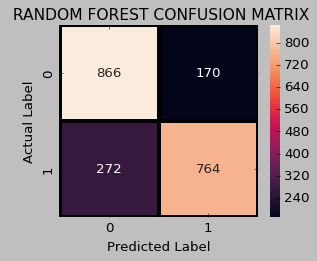

In [ ]:
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(Y_smote_test, Y_pred_rfc),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("RANDOM FOREST CONFUSION MATRIX",fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [ ]:
print(metrics.classification_report(Y_smote_test, Y_pred_rfc))

              precision    recall  f1-score   support

          No       0.76      0.84      0.80      1036
         Yes       0.82      0.74      0.78      1036

    accuracy                           0.79      2072
   macro avg       0.79      0.79      0.79      2072
weighted avg       0.79      0.79      0.79      2072



In [ ]:
print("Training Accuracy\t:", model_rfc.score(X_smote_train, Y_smote_train)*100)
print("Testing Accuracy\t:", model_rfc.score(X_smote_test, Y_smote_test)*100)

Training Accuracy	: 100.0
Testing Accuracy	: 78.66795366795367


In [ ]:
# Obtaining feature importances
model_rfc.feature_importances_

array([0.24217556, 0.03545902, 0.03249195, 0.00881485, 0.0361232 ,
       0.08054205, 0.04267253, 0.0359388 , 0.06085546, 0.02967966,
       0.02883868, 0.16249275, 0.03844273, 0.01783707, 0.01752661,
       0.01182583, 0.03292272, 0.00586538, 0.01442817, 0.01541465,
       0.03644244, 0.0132099 ])

In [ ]:
# Obtaining feature names
model_rfc.feature_names_in_

array(['customerID', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'gender_Female',
       'gender_Male', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype=object)

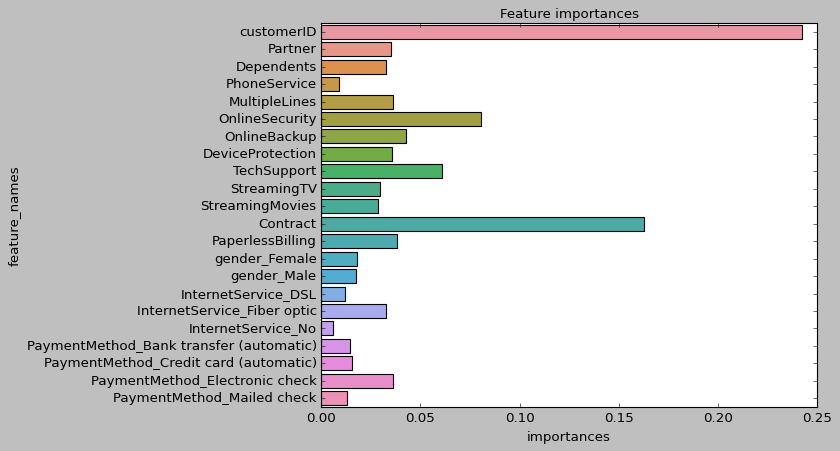

In [ ]:
# Creating importances_df dataframe
importances_df = pd.DataFrame({"feature_names" : model_rfc.feature_names_in_, 
                               "importances" : model_rfc.feature_importances_})
                             
# Plotting bar chart, g is from graph
g = sns.barplot(x=importances_df["importances"], 
                y=importances_df["feature_names"])
g.set_title("Feature importances", fontsize=12);            

## 6.5 Logistic Regression

In [ ]:
model_lr = LogisticRegression()
model_lr.fit(X_smote_train, Y_smote_train)

LogisticRegression()

In [ ]:
Y_train_lr = model_lr.predict(X_smote_train)
Y_test_lr = model_lr.predict(X_smote_test)

In [ ]:
classification_matrix(Y_smote_test, Y_test_lr, 'Logistic Regression Testing')

Evaluation Model: Logistic Regression Testing
[[733 303]
 [176 860]]
Accuracy   : 76.88 %
Precision  : 73.95 %
Recall     : 83.01 %
F1_Score   : 78 %


In [ ]:
print(confusion_matrix(Y_smote_test, Y_test_lr))
print(classification_report(Y_smote_test, Y_test_lr, target_names=['No', 'Yes']))

[[733 303]
 [176 860]]
              precision    recall  f1-score   support

          No       0.81      0.71      0.75      1036
         Yes       0.74      0.83      0.78      1036

    accuracy                           0.77      2072
   macro avg       0.77      0.77      0.77      2072
weighted avg       0.77      0.77      0.77      2072



In [ ]:
print("Training Accuracy\t:", model_lr.score(X_smote_train, Y_smote_train)*100)
print("Testing Accuracy\t:", model_lr.score(X_smote_test, Y_smote_test)*100)

Training Accuracy	: 75.91831802803286
Testing Accuracy	: 76.88223938223938


## 6.6 Naive Bayes

In [ ]:
model_nbc = GaussianNB()
model_nbc.fit(X_smote_train, Y_smote_train)

GaussianNB()

In [ ]:
Y_pred_nbc = model_nbc.predict(X_smote_test)

cm = confusion_matrix(Y_smote_test, Y_pred_nbc)
print(cm)
# sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)

# plt.xlabel('Predicted Label')
# plt.ylabel('Actual Label')
# plt.title("Confusion Matrix Naive Bayes with SMOTE", fontsize=14, fontname="Helvetica")

[[751 285]
 [180 856]]


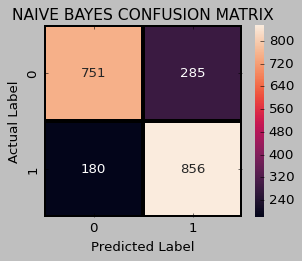

In [ ]:
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(Y_smote_test, Y_pred_nbc),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("NAIVE BAYES CONFUSION MATRIX",fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [ ]:
print(metrics.classification_report(Y_smote_test, Y_pred_nbc))

              precision    recall  f1-score   support

          No       0.81      0.72      0.76      1036
         Yes       0.75      0.83      0.79      1036

    accuracy                           0.78      2072
   macro avg       0.78      0.78      0.78      2072
weighted avg       0.78      0.78      0.78      2072



In [ ]:
print("Training Accuracy\t:", model_nbc.score(X_smote_train, Y_smote_train)*100)
print("Testing Accuracy\t:", model_nbc.score(X_smote_test, Y_smote_test)*100)

Training Accuracy	: 75.47124214596424
Testing Accuracy	: 77.55791505791507


## 6.7 Decision Tree

In [ ]:
model_dtc = DecisionTreeClassifier()
Y_predict_dtc = model_dtc.fit(X_smote_train, Y_smote_train).predict(X_smote_test)

In [ ]:
print(confusion_matrix(Y_smote_test, Y_predict_dtc))
print(classification_report(Y_smote_test, Y_predict_dtc, target_names=['No', 'Yes']))

[[804 232]
 [299 737]]
              precision    recall  f1-score   support

          No       0.73      0.78      0.75      1036
         Yes       0.76      0.71      0.74      1036

    accuracy                           0.74      2072
   macro avg       0.74      0.74      0.74      2072
weighted avg       0.74      0.74      0.74      2072



In [ ]:
print("Training Accuracy\t:", model_dtc.score(X_smote_train, Y_smote_train)*100)
print("Testing Accuracy\t:", model_dtc.score(X_smote_test, Y_smote_test)*100)

Training Accuracy	: 100.0
Testing Accuracy	: 74.37258687258688


## 6.8 KNN

In [ ]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_smote_train, Y_smote_train)

KNeighborsClassifier()

In [ ]:
Y_train_knn = model_knn.predict(X_smote_train)
Y_test_knn = model_knn.predict(X_smote_test)

In [ ]:
classification_matrix(Y_smote_test, Y_test_knn, 'KNN Testing')

Evaluation Model: KNN Testing
[[682 354]
 [249 787]]
Accuracy   : 70.9 %
Precision  : 68.97 %
Recall     : 75.97 %
F1_Score   : 72 %


In [ ]:
print(confusion_matrix(Y_smote_test, Y_test_knn))
print(classification_report(Y_smote_test, Y_test_knn, target_names=['No', 'Yes']))

[[682 354]
 [249 787]]
              precision    recall  f1-score   support

          No       0.73      0.66      0.69      1036
         Yes       0.69      0.76      0.72      1036

    accuracy                           0.71      2072
   macro avg       0.71      0.71      0.71      2072
weighted avg       0.71      0.71      0.71      2072



In [ ]:
print("Training Accuracy\t:", model_knn.score(X_smote_train, Y_smote_train)*100)
print("Testing Accuracy\t:", model_knn.score(X_smote_test, Y_smote_test)*100)

Training Accuracy	: 84.89608506524891
Testing Accuracy	: 70.8976833976834


# 7. SUMMARY

In [ ]:
klasifikasi_rfc = model_rfc.predict(X_test_dummy)
print(klasifikasi_rfc)

['Yes' 'No' 'No' ... 'No' 'No' 'No']


In [ ]:
prediksi = pd.DataFrame({'ID Customer': df.customerID, "Hasil Klasifikasi": klasifikasi_rfc})
prediksi.head()

ValueError: ignored

In [ ]:
prediksi["Hasil Klasifikasi"].value_counts()

KeyError: ignored